# Разработка модели для выявления нерациональных диагностических направлений

## Бизнес-задача
Задача от Службы внутреннего аудита поликлиники: выявлять случаи нерационального назначения медицинских исследований врачом пациенту. Из тысяч врачебных назначений модель должна отбирать потенциально нерациональные, которые на следующем этапе анализует врач-эксперт. Таким образом, модель помогает сфокусировать внимание эксперта и сэкономить его время.  
В качестве метрики оценки качества модели выбрана f1-мера, целевой уровень 0.88 и выше.
Предоставлен датасет за 6 месяцев (>200 тыс. наблюдений), размечен врачами-экспертами.  

## Цель
Разработать модель для выявления нерациональных диагностических назначений. Задача бинарной классификации. 

## План работы.
1. Загрузка, предобработка и анализ данных.  
2. Подготовка данных
3. Построение моделей и выбор лучшей.
4. Проверка лучшей модели на тестовой выборке.
5. Формулирование выводов. 

## Технический блок

### Импорты библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import phik

from catboost import CatBoostClassifier, Pool
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

### Собственные функции

In [2]:
def data_review(df_):
    """ Функция для первичного обзора данных
    Args:
        df_ - датасет
    Returns:
        Возвращаемых значений нет.
        Функция выводит следующие сведения:
        Кол-во строк
        Кол-во столбцов
        Кол-во явных дубликатов
        Пример датасета
        Таблицу с данными по каждому столбцу (тип данных, уникальных значений, кол-во пропусков, долю пропусков)
    """
    res_dupl = df.duplicated().sum()
    print('Строк:', df.shape[0],
            '\nСтолбцов:', df.shape[1],
            '\nКоличество явных дубликатов:', res_dupl,
            '\n\nПример датасета:')
    display(df.sample(5))

    # Обзорная информация о датасете
    print('Обзорная информация о датасете:')
    res = pd.DataFrame(columns=['Имя столбца','Тип данных','Уникальных значений','Число пропусков','Доля пропусков'])
    k=0
    for i in df_.columns:
        k += 1
        res.loc[k] = [i,
                    df_.dtypes[i],
                    len(df_[i].unique()),
                    df_[i].isna().sum(),
                    round(df_[i].isna().mean() * 100, 3)
                    ]
    display(res)

In [3]:
def research_data_analysis_plots (dataframe, bins=40, include_col=''):
    """ Функция рисует график для одного параметра датафрейма
    Args
        data(DataFrame) - датафрейм с данными
        bins(int)=40 - кол-во корзин гистограммы
        include_col([str]) - столбец, требующий
    Returns
        нет возвращаемых значений
    """
    num_types_list = ['int_', 'int8', 'int16', 'int32', 'int64', 'uint8', 'uint16', 'uint32', 'uint64',
                     'float_', 'float16', 'float32', 'float64']

    # сброс индекса в датафрейме для boxplot
    dataframe_ri = pd.DataFrame()
    dataframe_ri = dataframe.reset_index(drop=True)

    # Отрисовка графиков числовых переменных
    if dataframe.dtypes[include_col] in num_types_list:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,10))
        sns.histplot(data=dataframe[include_col], bins=bins, kde=False, ax=axes[0])  \
            .set_title('Числовой параметр: ' + include_col, fontdict={'fontsize':16})
        sns.boxplot(data=dataframe_ri, x=include_col, orient='h', ax=axes[1])
        plt.show

    # Отрисовка графиков категориальных переменных
    if dataframe.dtypes[include_col] in ['object','bool']:
        data_x = dataframe.groupby(include_col)[include_col].count().index
        data_y = dataframe.groupby(include_col)[include_col].count().values
        sns.barplot(y=data_x, x=data_y, orient='h')
        plt.title('Категориальный параметр: ' + include_col, fontdict={'fontsize':16})
        plt.xlabel('Кол-во наблюдений')
        plt.ylabel('Значение параметра')
        plt.show

## Загрузка, предобработка и анализ данных.

In [4]:
# Загрузка датафрейма
df = pd.read_csv('data/data.csv', decimal='.')
df.head(3)

,Unnamed: 0,test_code,test_name,appeal_reason,diagnose,price,target,age
0,0,B01,Иследование общего анализа мочи на анализаторе...,Острое заболевание (состояние)/Обострение хрон...,N15.8 Другие уточненные тубулоинтерстициальны...,555.32,0,53
1,1,B02,Общий анализ крови на анализаторе с дифференци...,Острое заболевание (состояние)/Обострение хрон...,N15.8 Другие уточненные тубулоинтерстициальны...,1687.40,0,53
2,2,B01,Исследование кала (копрограмма) общеклиническо...,Острое заболевание (состояние)/Обострение хрон...,B18.1 Хронический вирусный гепатит в без дел...,707.78,0,38


In [5]:
# Сохраним копию исходного датафрейма. Все эксперименты и преобразования проводим с df
df_init = df.copy()

In [6]:
# Обзор данных с помощью собственной функкции
data_review(df)

Строк: 200644 
Столбцов: 8 
Количество явных дубликатов: 0 

Пример датасета:


,Unnamed: 0,test_code,test_name,appeal_reason,diagnose,price,target,age
176286,195932,B06,Определение общего тироксина (T4) в сыворотке ...,Острое заболевание (состояние)/Обострение хрон...,E03.8 Другие уточненные гипотиреозы,1200.54,1,32
56084,62404,B01,Определение степени чистоты гинекологического ...,Острое заболевание (состояние)/Обострение хрон...,N95.1 Менопауза и климактерическое состояние ...,1236.81,0,50
107693,119729,B03,Определение мочевой кислоты в сыворотке крови ...,Острое заболевание (состояние)/Обострение хрон...,M15.0 Первичный генерализованный (остео)артроз,96.43,0,49
200631,222926,B03,Определение глюкозы в сыворотке крови на анали...,Прием при антенатальном наблюдении,"O28.8 Другие отклонения от нормы , выявленные...",102.77,0,33
153180,170201,B03,Определение аланинаминотрансферазы (АЛаТ) в сы...,Острое заболевание (состояние)/Обострение хрон...,E11.6 Инсулиннезависимый сахарный диабет с др...,91.46,0,63


Обзорная информация о датасете:


,Имя столбца,Тип данных,Уникальных значений,Число пропусков,Доля пропусков
1,Unnamed: 0,int64,200644,0,0.0
2,test_code,object,8,0,0.0
3,test_name,object,463,0,0.0
4,appeal_reason,object,20,0,0.0
5,diagnose,object,2030,0,0.0
6,price,float64,359,0,0.0
7,target,int64,2,0,0.0
8,age,int64,93,0,0.0


Датасет содержит более 200 тыс.строк, 8 столбцов. Явные дубликаты отсутствуют. Пропуски данных не выявлены.  
'Unnamed: 0' - неинформативный столбец, удаляем.  
Изучим каждый из столбцов внимательно.

In [7]:
# Unnamed: 0 - удаление
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(3)

,test_code,test_name,appeal_reason,diagnose,price,target,age
0,B01,Иследование общего анализа мочи на анализаторе...,Острое заболевание (состояние)/Обострение хрон...,N15.8 Другие уточненные тубулоинтерстициальны...,555.32,0,53
1,B02,Общий анализ крови на анализаторе с дифференци...,Острое заболевание (состояние)/Обострение хрон...,N15.8 Другие уточненные тубулоинтерстициальны...,1687.40,0,53
2,B01,Исследование кала (копрограмма) общеклиническо...,Острое заболевание (состояние)/Обострение хрон...,B18.1 Хронический вирусный гепатит в без дел...,707.78,0,38


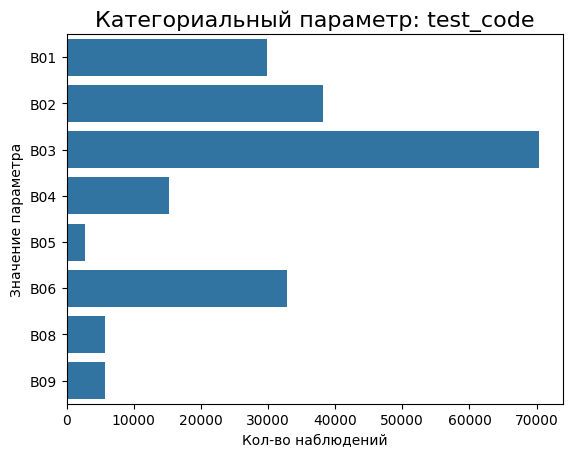

In [8]:
# Работа со столбцом 'test_code'
research_data_analysis_plots(df, include_col='test_code')

In [9]:
# Оценим долю для каждого значения test_code
df.test_code.value_counts().apply(lambda x: round(x/df.shape[0], 2))

test_code
B03    0.35
B02    0.19
B06    0.16
B01    0.15
B04    0.08
B08    0.03
B09    0.03
B05    0.01
Name: count, dtype: float64

test_code - групповой код исследования, 8 уникальных значений.  
В05, В08 и В09 - редко назначаемые (1-3% наблюдений), можно было объединить в одну категорию. Но пока оставлю как есть.

In [10]:
# Работа со столбцом 'test_name'
print('Всего разных услуг:', df.test_name.nunique())

Всего разных услуг: 463


In [11]:
# Редкие значения (встречаются 3 раза и реже в датасете) в столбце test_name заменяем на 'rare'
df_rare = pd.DataFrame(df.test_name.value_counts() < 4)
list_rare_test_name = df_rare[df_rare['count'] == True].index
print('Редкие услуги:', len(list_rare_test_name))

Редкие услуги: 150


In [12]:
# 150 видов редких исследований заменяем на 'rare'
df.loc[df.test_name.isin(list_rare_test_name), 'test_name'] = 'rare'
df.test_name.value_counts()

test_name
Иследование общего анализа мочи на анализаторе (физико-химические свойства с подсчетом количества клеточных элементов мочевого осадка)    20450
Общий анализ крови на анализаторе с дифференцировкой 5 классов клеток                                                                     19482
Измерение скорости оседания эритроцитов (СОЭ) в крови на анализаторе                                                                      13195
Определение глюкозы в сыворотке крови на анализаторе                                                                                       9451
Определение аланинаминотрансферазы (АЛаТ) в сыворотке крови на анализаторе                                                                 7744
                                                                                                                                          ...  
Определение опухолевого антигена (СА 72-4) в сыворотке крови методом иммунохемилюминесценции                                  

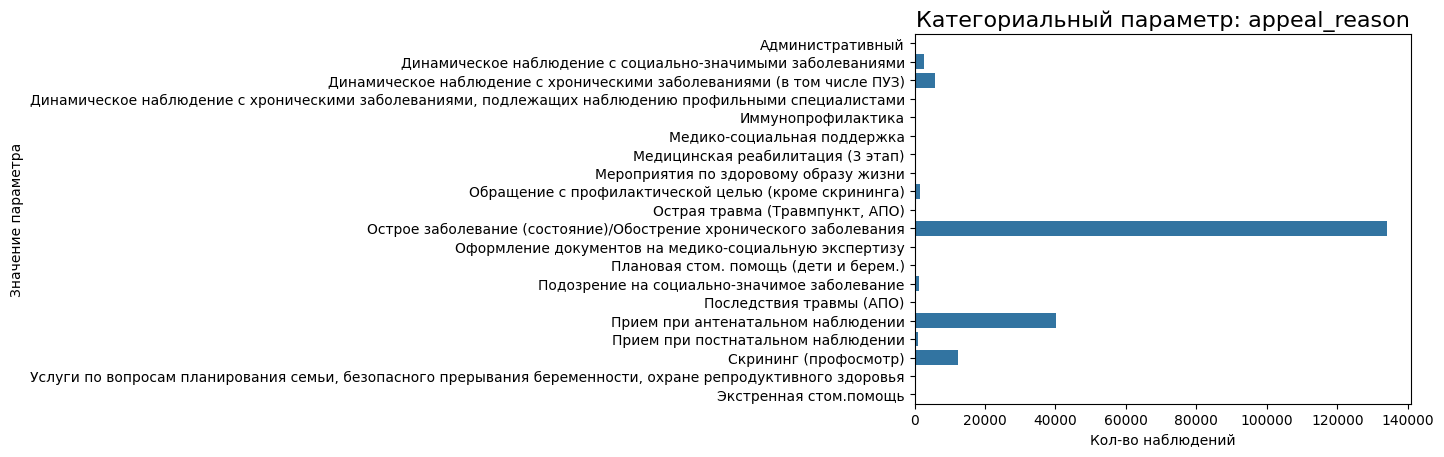

In [13]:
# Работа со столбцом 'appeal_reason'
research_data_analysis_plots(df, include_col='appeal_reason')

In [14]:
df.appeal_reason.unique()

array(['Острое заболевание (состояние)/Обострение хронического заболевания',
       'Динамическое наблюдение с хроническими заболеваниями (в том числе ПУЗ)',
       'Оформление документов на медико-социальную экспертизу',
       'Скрининг (профосмотр)', 'Прием при антенатальном наблюдении',
       'Подозрение на социально-значимое заболевание',
       'Обращение с профилактической целью (кроме скрининга)',
       'Динамическое наблюдение с социально-значимыми заболеваниями',
       'Административный', 'Последствия травмы (АПО)',
       'Прием при постнатальном наблюдении',
       'Услуги по вопросам планирования семьи, безопасного прерывания беременности, охране репродуктивного здоровья',
       'Динамическое наблюдение с хроническими заболеваниями, подлежащих наблюдению профильными специалистами',
       'Острая травма (Травмпункт, АПО)', 'Иммунопрофилактика',
       'Мероприятия по здоровому образу жизни',
       'Плановая стом. помощь (дети и берем.)',
       'Медико-социальная подд

In [15]:
# Объединяем все подвиды динамического наблюдения в одну категорию "динамическое наблюдение"
list_dinamic_monitoring = ['Динамическое наблюдение с хроническими заболеваниями (в том числе ПУЗ)',
        'Динамическое наблюдение с социально-значимыми заболеваниями',
        'Динамическое наблюдение с хроническими заболеваниями, подлежащих наблюдению профильными специалистами']
df.loc[df.appeal_reason.isin(list_dinamic_monitoring),'appeal_reason'] = 'Динамическое наблюдение'

In [16]:
# Оценим долю для каждого значения appeal_reason
appeal_reason_list = df.appeal_reason.value_counts().apply(lambda x: round(x/df.shape[0], 3))
appeal_reason_list

appeal_reason
Острое заболевание (состояние)/Обострение хронического заболевания                                             0.668
Прием при антенатальном наблюдении                                                                             0.199
Скрининг (профосмотр)                                                                                          0.062
Динамическое наблюдение                                                                                        0.045
Обращение с профилактической целью (кроме скрининга)                                                           0.008
Подозрение на социально-значимое заболевание                                                                   0.007
Прием при постнатальном наблюдении                                                                             0.005
Услуги по вопросам планирования семьи, безопасного прерывания беременности, охране репродуктивного здоровья    0.003
Последствия травмы (АПО)                          

In [17]:
# Выделим поводы обращения, встречающиеся чаще, чем в 1% случаев
appeal_reason_frequent = appeal_reason_list.loc[appeal_reason_list > 0.01].index
appeal_reason_frequent

Index(['Острое заболевание (состояние)/Обострение хронического заболевания',
       'Прием при антенатальном наблюдении', 'Скрининг (профосмотр)',
       'Динамическое наблюдение'],
      dtype='object', name='appeal_reason')

In [18]:
# Все остальные значения (реже 1%), объединяем в категорию "другое"
df.loc[~ df.appeal_reason.isin(appeal_reason_frequent),'appeal_reason'] = 'другое'
df.appeal_reason.unique()

array(['Острое заболевание (состояние)/Обострение хронического заболевания',
       'Динамическое наблюдение', 'другое', 'Скрининг (профосмотр)',
       'Прием при антенатальном наблюдении'], dtype=object)

In [19]:
# Работа со столбцом 'diagnose'
print('Всего разных диагнозов:', len(df.diagnose.unique()) )
# Редкие значения (встречаются 3 раза и реже в датасете) заменяем на 'rare'
df_rare = pd.DataFrame(df.diagnose.value_counts() < 4)
list_rare_diagnoses = df_rare[df_rare['count'] == True].index
print('Редкие диагнозы:', len(list_rare_diagnoses))

Всего разных диагнозов: 2030
Редкие диагнозы: 475


In [20]:
# 475 названий редких диагнозов заменяем на 'rare'
df.loc[df['diagnose'].isin(list_rare_diagnoses), 'diagnose'] = 'rare'
df.diagnose.value_counts()

diagnose
O26.8  Другие уточненные состояния, связанные с беременностью                                                                     23777
O28.8  Другие отклонения от нормы , выявленные при антенатальном обследовании матери                                              11516
Z11.5  Специальное скрининговое обследование с целью выявления других вирусных болезней                                            7128
I11.9  Гипертензивная (гипертоническая) болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности     6367
D50.9  Железодефицитная анемия неуточненная                                                                                        3726
                                                                                                                                  ...  
D51.3  Другие витамин-B12-дефицитные анемии, связанные с питанием                                                                     4
K07.6  Болезни височно-нижнечелюстного 

In [21]:
# Убираем текст диагноза, оставляем только код МКБ (уникальный)
df.diagnose = df.diagnose.apply(lambda x: x[:5])
df.head(3)

,test_code,test_name,appeal_reason,diagnose,price,target,age
0,B01,Иследование общего анализа мочи на анализаторе...,Острое заболевание (состояние)/Обострение хрон...,N15.8,555.32,0,53
1,B02,Общий анализ крови на анализаторе с дифференци...,Острое заболевание (состояние)/Обострение хрон...,N15.8,1687.40,0,53
2,B01,Исследование кала (копрограмма) общеклиническо...,Острое заболевание (состояние)/Обострение хрон...,B18.1,707.78,0,38


In [22]:
# Новая фича: групповой код МКБ - выделяем из diagnose
df['diagnose_group'] = df.diagnose.apply(lambda x: x[:3])
df.head(3)

,test_code,test_name,appeal_reason,diagnose,price,target,age,diagnose_group
0,B01,Иследование общего анализа мочи на анализаторе...,Острое заболевание (состояние)/Обострение хрон...,N15.8,555.32,0,53,N15
1,B02,Общий анализ крови на анализаторе с дифференци...,Острое заболевание (состояние)/Обострение хрон...,N15.8,1687.40,0,53,N15
2,B01,Исследование кала (копрограмма) общеклиническо...,Острое заболевание (состояние)/Обострение хрон...,B18.1,707.78,0,38,B18


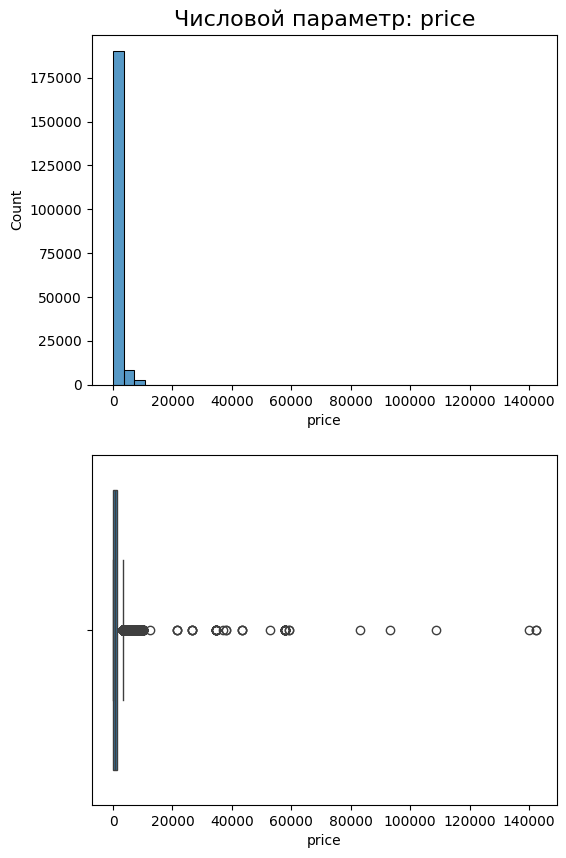

In [23]:
# Работа со столбцом 'price'
research_data_analysis_plots(df, include_col='price')

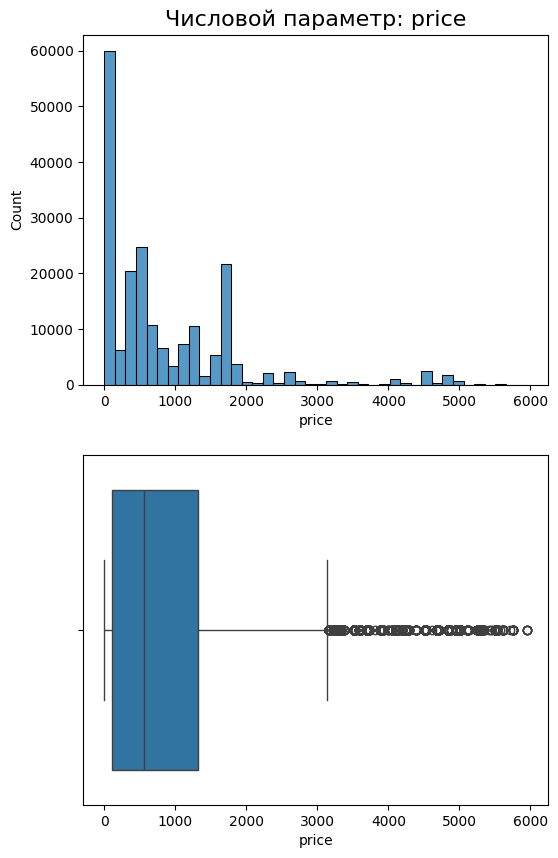

In [24]:
# Удаляем выбросы
df.drop(axis=0, index=df[df.price > 6000].index, inplace=True)
research_data_analysis_plots(df, include_col='price')

In [25]:
# Работа со столбцом 'target'.
df.target.value_counts().apply(lambda x: round(x/df.shape[0], 3))

target
0    0.959
1    0.041
Name: count, dtype: float64

target: имеем сильный дисбаланс классов. Положительный класс - 4%


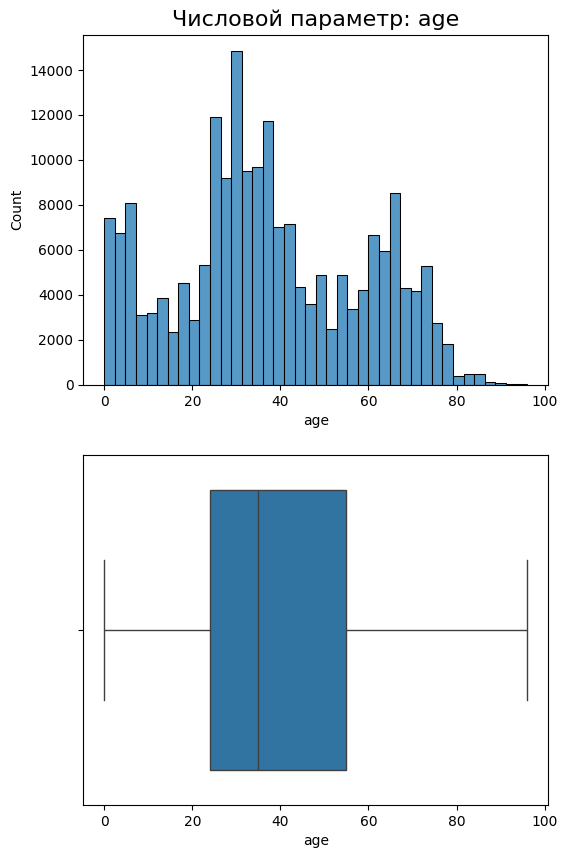

In [26]:
# Работа со столбцом 'age'.
research_data_analysis_plots(df, include_col='age')

In [27]:
# Оценим дубликаты
df.duplicated().sum()

101443

In [28]:
# После преобразований повилось 101 тыс. дубликтов. Удаляем.
df.drop_duplicates(inplace=True)
df.shape

(95648, 8)

Заключение по исследовательскому анализу и предобработке.
1. Удалены неинформативные столбцы.
2. Удалены дубликаты. Пропусков нет.
3. Обработаны категориальные переменные (объединение близких категорий, объединение редких категорий).
4. Удалены выбросы
5. Преобразованы данные по диагнозу, выделена дополнительная фича - групповой диагноз.

По итогу имеем датасет с 95 тыс. наблюдений.  
Доля положительного таргета 4,8 %, существеный дисбаланс классов.  

### Корреляционный анализ

interval_cols: ['price' 'target' 'age']


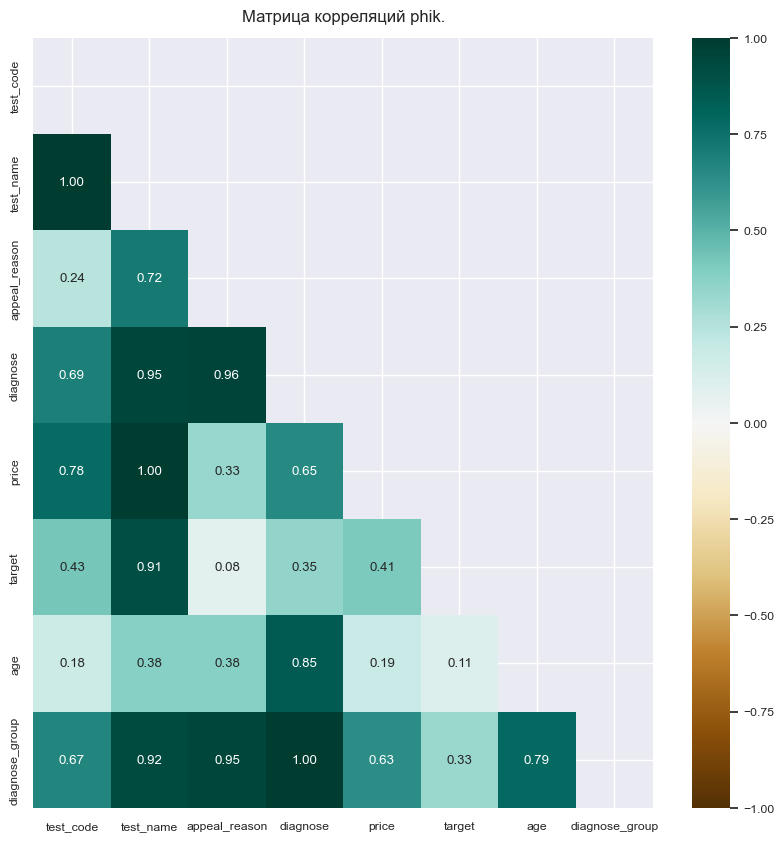

In [29]:
# Проведем корреляционный анализ
interv_col = df.select_dtypes(include='number').columns.values
print('interval_cols:', interv_col)
matr_corr_phik = df.phik_matrix(interval_cols=interv_col)
mask = np.triu(np.ones_like(df.phik_matrix(interval_cols=interv_col)))
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(matr_corr_phik,
                        vmin=-1,
                        vmax=1,
                        annot=True,
                        fmt='.2f',
                        cmap="BrBG",
                        mask=mask)
heatmap.set_title('Матрица корреляций phik.', fontdict={'fontsize':12}, pad=12);

Видим, что target имеет очень сильную корреляюцию с test_name, умеренную корреляцию с price, test_code и diagnose.  
Также видим очень сильную корреляцию между признаками:
* diagnose с diagnose_group, test_name, appeal_reason
* test_name с test_code, price и diagnose  

Удалим высокоскоррелированные параметры: test_code, price, diagnose_group

In [30]:
# удаляем столбцы
df.drop(columns=['test_code', 'price', 'diagnose_group'], inplace=True)

In [31]:
# Оценим дубликаты
df.duplicated().sum()

17

In [32]:
# Удалим образовавшиеся дубликаты
df.drop_duplicates(inplace=True)
df.shape

(95631, 5)

### Пайплайн для предобработки данных

In [33]:
# Обработка колонки "test_name"
class TestNameProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.loc[X.test_name.isin(list_rare_test_name), 'test_name'] = 'rare'
        return X

# Обработка колонки "diagnose"
class DiagnoseProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.loc[X.diagnose.isin(list_rare_diagnoses), 'diagnose'] = 'rare'
        X.diagnose = X.diagnose.apply(lambda x: x[:5])
        X['diagnose_group'] = X.diagnose.apply(lambda x: x[:3])
        return X

# Обработка колонки "appeal_reason"
class AppealReasonProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.loc[X.appeal_reason.isin(list_dinamic_monitoring),'appeal_reason'] = 'Динамическое наблюдение'
        X.loc[~ X.appeal_reason.isin(appeal_reason_frequent),'appeal_reason'] = 'другое'
        return X

# Обработка колонки "price"
class PriceProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
         return X.drop(axis=0, index=X[X.price > 6000].index)

# Удаление колонок
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(['Unnamed: 0', 'test_code', 'price', 'diagnose_group'], axis=1, errors='ignore')

# Общие преобразования
class GeneralProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop_duplicates()

In [34]:
pipeline_feature_prep = Pipeline([
    ('test_name_processor', TestNameProcessor()),
    ('diagnos_processor', DiagnoseProcessor()),
    ('appeal_reason_processor', AppealReasonProcessor()),
    ('price_processor', PriceProcessor()),
    ('feature_droper', FeatureDropper()),
    ('general_processor', GeneralProcessor())
])

In [35]:
# Проконтролируем корректность работы пайплайна предобработки
df_final = pipeline_feature_prep.fit_transform(df_init)
print('df_final:', df_final.shape, '\ndf:', df.shape)
display(df.head(3))
df_final.head(3)

df_final: (95631, 5) 
df: (95631, 5)


,test_name,appeal_reason,diagnose,target,age
0,Иследование общего анализа мочи на анализаторе...,Острое заболевание (состояние)/Обострение хрон...,N15.8,0,53
1,Общий анализ крови на анализаторе с дифференци...,Острое заболевание (состояние)/Обострение хрон...,N15.8,0,53
2,Исследование кала (копрограмма) общеклиническо...,Острое заболевание (состояние)/Обострение хрон...,B18.1,0,38


,test_name,appeal_reason,diagnose,target,age
0,Иследование общего анализа мочи на анализаторе...,Острое заболевание (состояние)/Обострение хрон...,N15.8,0,53
1,Общий анализ крови на анализаторе с дифференци...,Острое заболевание (состояние)/Обострение хрон...,N15.8,0,53
2,Исследование кала (копрограмма) общеклиническо...,Острое заболевание (состояние)/Обострение хрон...,B18.1,0,38


## Подготовка данных

In [36]:
# Определим константы
RANDOM_STATE = 42

# Определим X и y
X = df_final.drop('target', axis=1)
y = df_final.target

print(X.shape, y.shape)

(95631, 4) (95631,)


In [37]:
# Создаем списки переменных
# числовые
num_col = X.select_dtypes(include='number').columns.tolist()
# категориальные
cat_col = X.select_dtypes(exclude='number').columns.tolist()

print(f'Числовые: {num_col} \nНоминальные: {cat_col}' )

Числовые: ['age'] 
Номинальные: ['test_name', 'appeal_reason', 'diagnose']


In [38]:
# Таблица для метрик
df_metrics = pd.DataFrame(columns=['CatBoost', 'Network'],
                          index=['f1', 'precision', 'recall'])
df_metrics

,CatBoost,Network
f1,NaN,NaN
precision,NaN,NaN
recall,NaN,NaN


## Обучение моделей

В данных преобладают категориальные переменные с большим количеством уникальных значений.  
Для обучения возьмем CatBoost и нейросетевой вариант

### CatBoost

In [39]:
# Переводим данные в формат CatBoost
train_pool = Pool(X, y, cat_features=cat_col)

In [40]:
# Обучение модели
model_cb = CatBoostClassifier(loss_function='Logloss',
                              auto_class_weights='Balanced',
                              eval_metric='F1',
                              logging_level='Silent')
grid_cb = {
    'iterations': [150, 200, 250],
    'learning_rate': [0.05, 0.1],
    'depth':[6, 8, 10],
    'l2_leaf_reg':[0.2, 0.5, 1, 3]
}

In [41]:
_ = model_cb.randomized_search(grid_cb,
                               train_pool,
                               cv=5,
                               plot=True,
                               verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.9684971	best: 0.9684971 (0)	total: 6.91s	remaining: 1m 2s
9:	loss: 0.9907024	best: 0.9909999 (2)	total: 2m 52s	remaining: 0us
Estimating final quality...


In [42]:
# Модель с лучшими гиперпараметрами
model_cb.get_params()

{'loss_function': 'Logloss',
 'logging_level': 'Silent',
 'auto_class_weights': 'Balanced',
 'eval_metric': 'F1',
 'depth': 8,
 'learning_rate': 0.05,
 'l2_leaf_reg': 3,
 'iterations': 200}

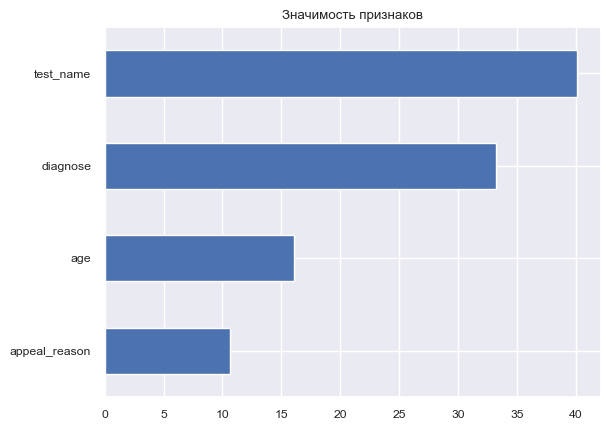

In [43]:
# Оцениваем значимость параметров
%matplotlib inline
pd.Series(index=model_cb.feature_names_, data=model_cb.feature_importances_)  \
        .sort_values()  \
        .plot(kind='barh')
_ = plt.title('Значимость признаков')
plt.show()

Весьма ожидаемо, что модель учитывает, прежде всего, название теста и диагноз. Свой вклад также вносят возраст и повод обращения.

In [44]:
# Фиксируем метрики
df_metrics.loc['f1', 'CatBoost'] = round(f1_score(y, model_cb.predict(X)), 3)
df_metrics.loc['precision', 'CatBoost'] = round(precision_score(y, model_cb.predict(X)), 3)
df_metrics.loc['recall', 'CatBoost'] = round(recall_score(y, model_cb.predict(X)), 3)
df_metrics

,CatBoost,Network
f1,0.995,NaN
precision,0.99,NaN
recall,0.999,NaN


### Нейросетевой подход

In [45]:
# Выделим валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

In [46]:
# Кодироваание категориальных данных
encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)
X_train_ohe = pd.DataFrame(encoder.fit_transform(X_train[cat_col]))
X_val_ohe = pd.DataFrame(encoder.transform(X_val[cat_col]))
X_train_ohe.shape

(76504, 1849)

In [47]:
# Нормализация числовых данных
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_col]))
X_val_scaled = pd.DataFrame(scaler.transform(X_val[num_col]))
X_train_scaled.shape

(76504, 1)

In [48]:
# Объединение числовых и категориальных данных (тренировочная выборка)
X_train_final = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_train_final.shape

(76504, 1850)

In [49]:
# Объединение числовых и категориальных данных (валидационная выборка)
X_val_final = pd.concat([X_val_scaled, X_val_ohe], axis=1)
X_val_final.shape

(19127, 1850)

In [50]:
# Обучение модели
optimizer = Adam(learning_rate=0.003)
model_nw = keras.Sequential([
    keras.layers.Dense(500, input_shape=(X_train_final.shape[1],), activation='relu'),
    keras.layers.Dense(120, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
    ])
model_nw.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['acc'])

# Параметры ранней остановки
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)
history = model_nw.fit(X_train_final, y_train, epochs=20, validation_data=(X_val_final, y_val), callbacks=[early_stopping])

Epoch 1/20
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - acc: 0.9724 - loss: 0.0667 - val_acc: 0.9913 - val_loss: 0.0208
Epoch 2/20
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - acc: 0.9950 - loss: 0.0125 - val_acc: 0.9936 - val_loss: 0.0161
Epoch 3/20
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - acc: 0.9983 - loss: 0.0051 - val_acc: 0.9935 - val_loss: 0.0214
Epoch 4/20
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - acc: 0.9991 - loss: 0.0023 - val_acc: 0.9934 - val_loss: 0.0254
Epoch 5/20
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - acc: 0.9991 - loss: 0.0024 - val_acc: 0.9949 - val_loss: 0.0215
Epoch 6/20
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - acc: 0.9991 - loss: 0.0022 - val_acc: 0.9931 - val_loss: 0.0287
Epoch 7/20
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - acc: 0.9995 - loss: 0.0015 - val_acc: 0.9927 - val_loss: 0.0374
Epoch 8/20
2391/2391 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - acc: 0.9995 - loss: 0.0016 - val_acc: 0.9944 - val_loss: 0.0290
Epoch 9/20
2391/2391 ━━━━━━━━━━━

In [51]:
# Приводим выводы модели к бинарному формату
prediction_train = [1 if prob > 0.5 else 0 for prob in model_nw.predict(X_train_final)]
prediction_val = [1 if prob > 0.5 else 0 for prob in model_nw.predict(X_val_final)]

print('f1 на трейне:', round(f1_score(y_train, prediction_train), 3))
print('f1 на тесте:', round(f1_score(y_val, prediction_val), 3))

2391/2391 ━━━━━━━━━━━━━━━━━━━━ 2s 774us/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
f1 на трейне: 0.982
f1 на тесте: 0.934


In [52]:
# Фиксируем метрики
df_metrics.loc['f1', 'Network'] = round(f1_score(y_train, prediction_train), 3)
df_metrics.loc['precision', 'Network'] = round(precision_score(y_train, prediction_train), 3)
df_metrics.loc['recall', 'Network'] = round(recall_score(y_train, prediction_train), 3)
df_metrics

,CatBoost,Network
f1,0.995,0.982
precision,0.99,0.979
recall,0.999,0.986


### Выводы по обучению моделей и выбор лучшей модели.
Обе модели показали очень высокие значения метрики на трейне. CatBoost демонстрирует f1-метрику 0.99, нейросеть - 0.98.  
Выбираем CatBoost как более точную, и, к тому же, менее сложную модель.

# Проверка лучшей модели на тестовой выборке

In [53]:
# Загрузка тестового датасета
df_test = pd.read_csv('data/data_test.csv')
print(df_test.shape)
df_test.head(3)

(22294, 8)


,Unnamed: 0,test_code,test_name,appeal_reason,diagnose,price,target,age
0,153437,B06,Определение резус-фактора крови,Прием при антенатальном наблюдении,"O26.8 Другие уточненные состояния, связанные ...",1548.68,0,36
1,125988,B03,Определение гаммаглютамилтранспептидазы (ГГТП)...,Острое заболевание (состояние)/Обострение хрон...,K59.9 Функциональное нарушение кишечника неут...,106.53,0,3
2,190423,B03,Определение общего белка в сыворотке крови на ...,Прием при антенатальном наблюдении,"O26.8 Другие уточненные состояния, связанные ...",90.83,0,30


In [54]:
# Прогоняем тестовый датафрейм через пайплайн предобработки
df_test_final = pipeline_feature_prep.fit_transform(df_test)
print(df_test_final.shape)
df_test_final.head(3)

(16289, 5)


,test_name,appeal_reason,diagnose,target,age
0,Определение резус-фактора крови,Прием при антенатальном наблюдении,O26.8,0,36
1,Определение гаммаглютамилтранспептидазы (ГГТП)...,Острое заболевание (состояние)/Обострение хрон...,K59.9,0,3
2,Определение общего белка в сыворотке крови на ...,Прием при антенатальном наблюдении,O26.8,0,30


In [55]:
# Определим X и y
X_test = df_test_final.drop('target', axis=1)
y_test = df_test_final.target

print(X_test.shape, y_test.shape)

(16289, 4) (16289,)


In [56]:
print('f1 на тестовой выборке:', round(f1_score(y_test, model_cb.predict(X_test)), 3))

f1 на тестовой выборке: 0.942


In [57]:
# Сохраняем модель
joblib.dump(model_cb, 'model_cb/model_cb.pkl')

['model_cb/model_cb.pkl']

In [58]:
# Сохраняем переменные для последующей предобработки реальных данных
with open('model_cb\list_rare_test_name.txt', 'w', encoding="utf-8") as file:
    for item in list_rare_test_name:
        file.write(item + '\n')

with open('model_cb\list_rare_diagnoses.txt', 'w', encoding="utf-8") as file:
    for item in list_rare_diagnoses:
        file.write(item + '\n')

with open('model_cb\list_dinamic_monitoring.txt', 'w', encoding="utf-8") as file:
    for item in list_dinamic_monitoring:
        file.write(item + '\n')

with open('model_cb\ppeal_reason_frequent.txt', 'w', encoding="utf-8") as file:
    for item in appeal_reason_frequent:
        file.write(item + '\n')

# Выводы
1. Целью проекта было обучение модели для выявления нерациональных диагностических назначений врачей. Предоставлен датасет с данными за 6 месяцев, более 200 тыс. наблюдений.
2. На этапе исследовательского анализа и предобработки:
* изучено распределение данных
* удалены дубликаты
* обработаны категориальные переменные
* удалены выбросы
* создан новый параметр
Этапы предобработки реализованы в форме пайплайна.
3. По итогу корреляционного анализа удалены несколько высокоскоррелированных параметров
4. Обучены две модели - CatBoost и нейросеть. f1-мера на трейне: CatBoost - 0.99 и нейросеть - 0.98.  
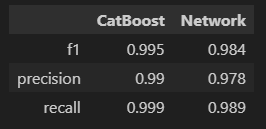  
Выбрана модель на базе градиентного бустинга как более точная и более простая. На тестовых данных модель показала точность 0.94, что удовлетворяет требованиям заказчика.
5. Работа модели основана на сопоставлении диагноза и назначенного исследования, модель также учитывает возраст пациента и повод обращения. Таким образом, разработана модель, способная определять случаи нерационального назначения диагностических процедур.

Рекомендации заказчику.  

Несколько увеличить метрику качества можно, если предоставить больше параметров для анализа. Также, развивая идею контроля врачебных назначений, можно разработать модель, анализирующую протокол приема врача средствами NLP, которая могла бы оценить соответствие жалоб и выявленных симптомов установленному диагнозу, а также корректность данных пациенту рекомендаций.